# 03 - Sanadset Exploration

This notebook explores the Sanadset tagged hadith corpus.

It covers:
- dataset loading and schema checks,
- `<NAR>` narrator extraction and frequency analysis,
- `<SANAD>` vs `<MATN>` split statistics,
- quality checks for malformed tags and gaps,
- fuzzy coverage comparison against `hadith-json` (`bukhari.json`).


In [1]:
from __future__ import annotations

import json
import re
from collections import Counter, defaultdict
from difflib import SequenceMatcher
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display


def find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / 'data').exists() and (candidate / 'notebooks').exists():
            return candidate
    return start


ROOT = find_project_root(Path.cwd().resolve())
DATA_DIR = ROOT / 'data' / 'raw'
SANADSET_PATH = DATA_DIR / 'sanadset' / 'sanadset.csv'
BUKHARI_PATH = DATA_DIR / 'hadith_json' / 'bukhari.json'

NAR_PATTERN = re.compile(r'<NAR>(.*?)</NAR>', re.IGNORECASE | re.DOTALL)
SANAD_PATTERN = re.compile(r'<SANAD>(.*?)</SANAD>', re.IGNORECASE | re.DOTALL)
MATN_PATTERN = re.compile(r'<MATN>(.*?)</MATN>', re.IGNORECASE | re.DOTALL)
NAR_TOKEN_PATTERN = re.compile(r'</?NAR>', re.IGNORECASE)
TAG_STRIP_PATTERN = re.compile(r'</?(?:NAR|SANAD|MATN)>', re.IGNORECASE)

ARABIC_DIACRITICS = re.compile(r'[\u0617-\u061A\u064B-\u0652\u0670\u0640]')
NON_WORD_PATTERN = re.compile(r'[^\w\s]', re.UNICODE)


def normalize_spaces(text: str) -> str:
    return re.sub(r'\s+', ' ', text).strip()


def strip_known_tags(text: str) -> str:
    if not isinstance(text, str):
        return ''
    stripped = TAG_STRIP_PATTERN.sub(' ', text)
    stripped = re.sub(r'<[^>]+>', ' ', stripped)
    return normalize_spaces(stripped)


def infer_tagged_text_column(df: pd.DataFrame) -> str:
    scores = []
    for col in df.columns:
        series = df[col]
        if not (pd.api.types.is_string_dtype(series) or series.dtype == object):
            continue
        sample = series.dropna().astype(str).head(500)
        if sample.empty:
            continue
        hit_rate = sample.str.contains(r'</?(?:NAR|SANAD|MATN)>', regex=True).mean()
        if hit_rate > 0:
            scores.append((hit_rate, col))

    if scores:
        scores.sort(reverse=True)
        return scores[0][1]

    preferred = ['tagged_text', 'text', 'hadith_text', 'hadith', 'sentence', 'content']
    lower_map = {c.lower(): c for c in df.columns}
    for key in preferred:
        if key in lower_map:
            return lower_map[key]

    for col in df.columns:
        series = df[col]
        if pd.api.types.is_string_dtype(series) or series.dtype == object:
            return col

    raise ValueError('Could not infer a text column in Sanadset CSV.')


def infer_id_column(df: pd.DataFrame) -> str:
    preferred = ['id', 'hadith_id', 'hadithid', 'hadith_no', 'index']
    lower_map = {c.lower(): c for c in df.columns}
    for key in preferred:
        if key in lower_map:
            return lower_map[key]
    return ''


def extract_narrators(text: str) -> list[str]:
    if not isinstance(text, str):
        return []
    narrators = []
    for match in NAR_PATTERN.findall(text):
        candidate = strip_known_tags(match)
        if candidate:
            narrators.append(candidate)
    return narrators


def extract_tag_content(text: str, pattern) -> str:
    if not isinstance(text, str):
        return ''
    parts = [strip_known_tags(part) for part in pattern.findall(text)]
    parts = [part for part in parts if part]
    return normalize_spaces(' '.join(parts))


def highlight_narrators_in_sanad(text: str) -> str:
    if not isinstance(text, str):
        return ''
    sanad_parts = SANAD_PATTERN.findall(text)
    if not sanad_parts:
        return ''
    combined = ' '.join(sanad_parts)

    def _repl(match):
        inner = normalize_spaces(strip_known_tags(match.group(1)))
        return f'[[{inner}]]' if inner else ''

    highlighted = re.sub(r'<NAR>(.*?)</NAR>', _repl, combined, flags=re.IGNORECASE | re.DOTALL)
    highlighted = TAG_STRIP_PATTERN.sub(' ', highlighted)
    highlighted = re.sub(r'<[^>]+>', ' ', highlighted)
    return normalize_spaces(highlighted)


def word_count(text: str) -> int:
    if not isinstance(text, str) or not text.strip():
        return 0
    return len(re.findall(r'\S+', text))


def nar_tag_quality_flags(text: str) -> tuple[bool, bool]:
    if not isinstance(text, str):
        return False, False
    depth = 0
    malformed = False
    nested = False

    for token in NAR_TOKEN_PATTERN.findall(text):
        if token.lower() == '<nar>':
            if depth > 0:
                nested = True
            depth += 1
        else:
            if depth == 0:
                malformed = True
            else:
                depth -= 1

    if depth != 0:
        malformed = True

    return malformed, nested


def normalize_for_match(text: str) -> str:
    cleaned = strip_known_tags(text)
    cleaned = ARABIC_DIACRITICS.sub('', cleaned)
    cleaned = cleaned.replace('أ', 'ا').replace('إ', 'ا').replace('آ', 'ا')
    cleaned = cleaned.replace('ى', 'ي').replace('ة', 'ه')
    cleaned = NON_WORD_PATTERN.sub(' ', cleaned)
    return normalize_spaces(cleaned)


def shorten(text: str, limit: int = 170) -> str:
    if not isinstance(text, str):
        return ''
    if len(text) <= limit:
        return text
    return text[:limit].rstrip() + '...'


if not SANADSET_PATH.exists():
    raise FileNotFoundError(
        f'{SANADSET_PATH} not found. Run `python scripts/download_sanadset.py` first '
        'or manually place the CSV at this path.'
    )

print('Project root:', ROOT)
print('Sanadset path:', SANADSET_PATH)
print('Bukhari path:', BUKHARI_PATH)


Project root: C:\Users\diaab\islamic-ner
Sanadset path: C:\Users\diaab\islamic-ner\data\raw\sanadset\sanadset.csv
Bukhari path: C:\Users\diaab\islamic-ner\data\raw\hadith_json\bukhari.json


## A) Load Sanadset CSV and inspect structure

This section loads the CSV and reports:
- total hadith count,
- column names and dtypes,
- 10 sample hadiths from the tagged text column.


In [2]:
encodings = ['utf-8', 'utf-8-sig', 'cp1256', 'windows-1256']
sanad_df = None
last_error = None

for enc in encodings:
    try:
        sanad_df = pd.read_csv(SANADSET_PATH, encoding=enc)
        print(f'Loaded Sanadset with encoding: {enc}')
        break
    except UnicodeDecodeError as exc:
        last_error = exc

if sanad_df is None:
    raise RuntimeError(f'Failed to load CSV with tried encodings: {encodings}. Last error: {last_error}')

if sanad_df.empty:
    raise ValueError('Sanadset CSV loaded but is empty.')

sanad_df = sanad_df.reset_index(drop=True)
tagged_col = infer_tagged_text_column(sanad_df)
id_col = infer_id_column(sanad_df)
if not id_col:
    sanad_df = sanad_df.reset_index().rename(columns={'index': 'row_id'})
    id_col = 'row_id'

print(f'Total number of hadiths: {len(sanad_df):,}')
print(f'Tagged text column selected: {tagged_col}')
print(f'ID column selected: {id_col}')

dtype_df = pd.DataFrame({'column': sanad_df.columns, 'dtype': sanad_df.dtypes.astype(str)})
display(dtype_df)

sample_n = min(10, len(sanad_df))
sample_df = sanad_df[[id_col, tagged_col]].sample(sample_n, random_state=42)
display(sample_df)


Loaded Sanadset with encoding: utf-8
Total number of hadiths: 956
Tagged text column selected: Book
ID column selected: row_id


,column,dtype
row_id,row_id,int64
Book,Book,object


,row_id,Book
342,342,المنتخب من شيوخ بغداد
864,864,مسند عمر بن عبد العزيز للباغندي
522,522,فضائل شهر رمضان لعبد الغني المقدسي
544,544,ذكر الأوهام في المشايخ النبلاء لضياء الدين الم...
682,682,الرابع من حديث أبي طاهر المخلص
136,136,أخبار مكة للفاكهي
213,213,إكرام الضيف للحربي
168,168,المنامات لابن أبي الدنيا
86,86,الأوهام التي في مدخل الحاكم لعبد الغني الأزدي
281,281,منتقى حديث أبي عبد الله محمد بن مخلد


## B) Parse `<NAR>` tags and narrator statistics

We extract all narrators from `<NAR>...</NAR>` tags, then compute:
- unique narrator count,
- top 50 most frequent narrators,
- histogram of narrators-per-hadith.


Total narrator mentions: 0
Unique narrators: 0


,narrator,frequency


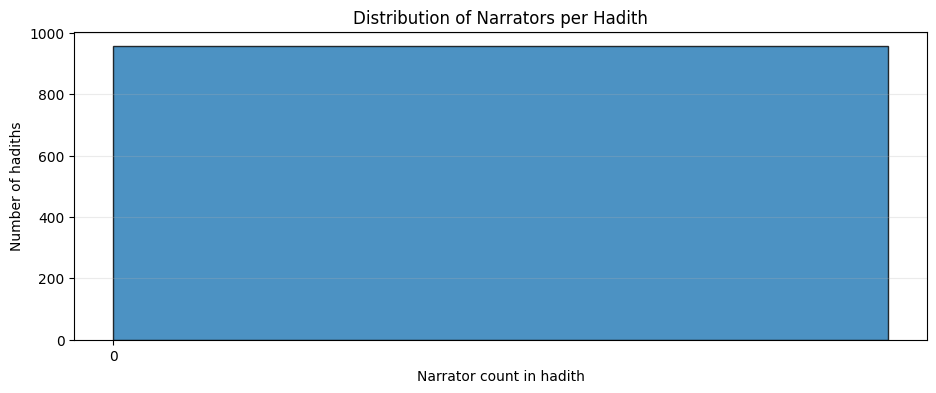

In [3]:
sanad_df['narrators'] = sanad_df[tagged_col].astype(str).apply(extract_narrators)
sanad_df['narrator_count'] = sanad_df['narrators'].apply(len)

all_narrators = [name for names in sanad_df['narrators'] for name in names]
narrator_freq = Counter(all_narrators)

print(f'Total narrator mentions: {len(all_narrators):,}')
print(f'Unique narrators: {len(narrator_freq):,}')

top50_df = pd.DataFrame(narrator_freq.most_common(50), columns=['narrator', 'frequency'])
display(top50_df)

plt.figure(figsize=(11, 4))
max_count = int(sanad_df['narrator_count'].max()) if len(sanad_df) else 0
bins = range(0, max_count + 2)
plt.hist(sanad_df['narrator_count'], bins=bins, edgecolor='black', alpha=0.8)
plt.title('Distribution of Narrators per Hadith')
plt.xlabel('Narrator count in hadith')
plt.ylabel('Number of hadiths')
plt.xticks(range(0, min(max_count + 1, 25)))
plt.grid(axis='y', alpha=0.25)
plt.show()


## C) Analyze `<SANAD>` vs `<MATN>` split

This section computes isnad/matn lengths (word-based), reports coverage of both tags,
and shows sample isnad snippets with narrators highlighted as `[[name]]`.


In [4]:
sanad_df['sanad_text'] = sanad_df[tagged_col].astype(str).apply(lambda x: extract_tag_content(x, SANAD_PATTERN))
sanad_df['matn_text'] = sanad_df[tagged_col].astype(str).apply(lambda x: extract_tag_content(x, MATN_PATTERN))

sanad_df['sanad_words'] = sanad_df['sanad_text'].apply(word_count)
sanad_df['matn_words'] = sanad_df['matn_text'].apply(word_count)

has_sanad = sanad_df['sanad_text'].str.len() > 0
has_matn = sanad_df['matn_text'].str.len() > 0
has_both = has_sanad & has_matn

avg_isnad_words = sanad_df.loc[has_sanad, 'sanad_words'].mean() if has_sanad.any() else 0.0
avg_matn_words = sanad_df.loc[has_matn, 'matn_words'].mean() if has_matn.any() else 0.0
pct_both = (has_both.mean() * 100) if len(sanad_df) else 0.0

print(f'Average isnad length (words): {avg_isnad_words:.2f}')
print(f'Average matn length (words): {avg_matn_words:.2f}')
print(f'Percentage with both <SANAD> and <MATN>: {pct_both:.2f}%')

sanad_df['sanad_highlighted'] = sanad_df[tagged_col].astype(str).apply(highlight_narrators_in_sanad)
isnad_sample = sanad_df.loc[sanad_df['sanad_highlighted'].str.len() > 0, [id_col, 'sanad_highlighted']]

if isnad_sample.empty:
    print('No <SANAD> sections found for highlighting.')
else:
    display(isnad_sample.sample(min(10, len(isnad_sample)), random_state=42))


Average isnad length (words): 0.00
Average matn length (words): 0.00
Percentage with both <SANAD> and <MATN>: 0.00%
No <SANAD> sections found for highlighting.


## D) Quality checks

Checks performed:
- malformed or nested `<NAR>` tags,
- narrators with very long names (>6 words),
- hadiths with zero narrator tags.


In [5]:
flags = sanad_df[tagged_col].astype(str).apply(nar_tag_quality_flags)
sanad_df['nar_malformed'] = flags.apply(lambda x: x[0])
sanad_df['nar_nested'] = flags.apply(lambda x: x[1])

issue_df = sanad_df[sanad_df['nar_malformed'] | sanad_df['nar_nested']].copy()
print(f'Hadiths with malformed/nested <NAR> tags: {len(issue_df):,}')
if not issue_df.empty:
    display(issue_df[[id_col, 'nar_malformed', 'nar_nested', tagged_col]].head(20))

long_narrators = []
for narrator, freq in narrator_freq.items():
    words = word_count(narrator)
    if words > 6:
        long_narrators.append((narrator, words, freq))

long_narrators_df = pd.DataFrame(long_narrators, columns=['narrator', 'word_count', 'frequency'])
if long_narrators_df.empty:
    print('No narrator names with >6 words were found.')
else:
    long_narrators_df = long_narrators_df.sort_values(['frequency', 'word_count'], ascending=False)
    print(f'Narrators with very long names (>6 words): {len(long_narrators_df):,}')
    display(long_narrators_df.head(50))

zero_narr_df = sanad_df[sanad_df['narrator_count'] == 0].copy()
zero_pct = (len(zero_narr_df) / len(sanad_df) * 100) if len(sanad_df) else 0.0
print(f'Hadiths with 0 narrators tagged: {len(zero_narr_df):,} ({zero_pct:.2f}%)')
if not zero_narr_df.empty:
    display(zero_narr_df[[id_col, tagged_col]].head(20))


Hadiths with malformed/nested <NAR> tags: 0
No narrator names with >6 words were found.
Hadiths with 0 narrators tagged: 956 (100.00%)


,row_id,Book
0,0,مسند الربيع بن حبيب
1,1,تفسير مجاهد
2,2,مسند زيد
3,3,مسانيد فراس المكتب رواية أبي نعيم
4,4,حديث أيوب السختياني
5,5,صحيفة همام بن منبه
6,6,مسند أبي حنيفة رواية أبي نعيم
7,7,جزء ابن جريج
8,8,الجامع لمعمر بن راشد
9,9,المناسك لسعيد بن أبي عروبة


## E) Compare with hadith-json (`bukhari.json`) using fuzzy matching

Process:
- sample 100 random hadiths from `bukhari.json`,
- normalize text and compare against Sanadset hadith text,
- estimate coverage using a fuzzy score threshold.


In [6]:
def extract_hadith_records(payload):
    if isinstance(payload, list):
        return payload
    if not isinstance(payload, dict):
        return []

    candidates = []
    for key in ['hadiths', 'data', 'items', 'results']:
        value = payload.get(key)
        if isinstance(value, list):
            candidates.append(value)
        elif isinstance(value, dict):
            nested = value.get('hadiths')
            if isinstance(nested, list):
                candidates.append(nested)

    if candidates:
        return max(candidates, key=len)
    return []


def extract_hadith_text(record):
    text_keys = ['hadithArabic', 'arabic', 'arab', 'text', 'hadith', 'matn']
    for key in text_keys:
        value = record.get(key)
        if isinstance(value, str) and value.strip():
            return value.strip()

    for value in record.values():
        if isinstance(value, str) and len(value.split()) >= 5:
            return value.strip()
    return ''


def extract_hadith_id(record, fallback):
    id_keys = ['hadithnumber', 'hadithNumber', 'id', 'arabicnumber', 'number']
    for key in id_keys:
        value = record.get(key)
        if isinstance(value, (str, int)):
            return str(value)
    return str(fallback)


if not BUKHARI_PATH.exists():
    print(f'{BUKHARI_PATH} not found. Run `python scripts/download_data.py` and rerun this section.')
else:
    with BUKHARI_PATH.open('r', encoding='utf-8') as handle:
        bukhari_payload = json.load(handle)

    raw_records = extract_hadith_records(bukhari_payload)
    bukhari_rows = []
    for idx, rec in enumerate(raw_records):
        if not isinstance(rec, dict):
            continue
        text = extract_hadith_text(rec)
        if not text:
            continue
        bukhari_rows.append({'bukhari_id': extract_hadith_id(rec, idx), 'text': text})

    bukhari_df = pd.DataFrame(bukhari_rows)
    if bukhari_df.empty:
        print('Could not extract hadith texts from bukhari.json schema.')
    else:
        sample_size = min(100, len(bukhari_df))
        bukhari_sample = bukhari_df.sample(sample_size, random_state=42).reset_index(drop=True)
        print(f'Sampled {sample_size} hadiths from bukhari.json')

        sanad_plain = sanad_df[tagged_col].astype(str).apply(strip_known_tags)
        sanad_norm = sanad_plain.apply(normalize_for_match)
        sanad_lengths = sanad_norm.apply(len)

        token_index = defaultdict(set)
        for i, text in enumerate(sanad_norm):
            tokens = {tok for tok in text.split() if len(tok) >= 4}
            for tok in tokens:
                token_index[tok].add(i)

        def candidate_pool(query_norm):
            tokens = sorted({tok for tok in query_norm.split() if len(tok) >= 4}, key=len, reverse=True)
            candidates = set()
            for tok in tokens[:12]:
                candidates.update(token_index.get(tok, set()))
                if len(candidates) > 4000:
                    break
            return candidates

        threshold = 0.60
        results = []

        for _, row in bukhari_sample.iterrows():
            query_raw = row['text']
            query_norm = normalize_for_match(query_raw)
            if not query_norm:
                continue

            candidates = candidate_pool(query_norm)
            if not candidates:
                continue

            if len(candidates) > 1200:
                candidates = sorted(candidates, key=lambda i: abs(sanad_lengths.iloc[i] - len(query_norm)))[:1200]

            best_idx = None
            best_score = 0.0
            for cand_idx in candidates:
                score = SequenceMatcher(None, query_norm, sanad_norm.iloc[cand_idx]).ratio()
                if score > best_score:
                    best_score = score
                    best_idx = cand_idx

            if best_idx is None:
                continue

            results.append(
                {
                    'bukhari_id': row['bukhari_id'],
                    'score': round(best_score, 4),
                    'matched_sanadset_id': sanad_df.iloc[best_idx][id_col],
                    'bukhari_text_sample': shorten(query_raw),
                    'sanadset_text_sample': shorten(sanad_plain.iloc[best_idx]),
                }
            )

        if not results:
            print('No fuzzy matches were produced. Check text normalization or data availability.')
        else:
            matches_df = pd.DataFrame(results).sort_values('score', ascending=False)
            covered = int((matches_df['score'] >= threshold).sum())
            coverage_pct = (covered / sample_size) * 100 if sample_size else 0.0
            print(f'Coverage at threshold >= {threshold:.2f}: {covered}/{sample_size} ({coverage_pct:.2f}%)')
            display(matches_df.head(25))


Sampled 100 hadiths from bukhari.json
Coverage at threshold >= 0.60: 0/100 (0.00%)


,bukhari_id,score,matched_sanadset_id,bukhari_text_sample,sanadset_text_sample
19,4963,0.4891,845,حَدَّثَنَا مَالِكُ بْنُ إِسْمَاعِيلَ، حَدَّثَن...,المفاريد عن رسول الله صلى الله عليه وسلم لأبي ...
20,5503,0.4324,211,حَدَّثَنِي مُحَمَّدُ بْنُ الْمُثَنَّى، حَدَّثَ...,فضل الصلاة على النبي صلى الله عليه وسلم لإسماع...
70,5134,0.4186,211,حَدَّثَنَا عَلِيُّ بْنُ الْجَعْدِ، أَخْبَرَنَا...,فضل الصلاة على النبي صلى الله عليه وسلم لإسماع...
45,3659,0.4147,845,حَدَّثَنَا إِسْحَاقُ الْوَاسِطِيُّ، حَدَّثَنَا...,المفاريد عن رسول الله صلى الله عليه وسلم لأبي ...
24,3205,0.4103,211,حَدَّثَنِي مُحَمَّدُ بْنُ عَرْعَرَةَ، حَدَّثَن...,فضل الصلاة على النبي صلى الله عليه وسلم لإسماع...
64,5013,0.4095,845,حَدَّثَنَا مُوسَى بْنُ إِسْمَاعِيلَ، حَدَّثَنَ...,المفاريد عن رسول الله صلى الله عليه وسلم لأبي ...
33,409,0.4000,845,حَدَّثَنَا آدَمُ، قَالَ حَدَّثَنَا شُعْبَةُ، ق...,المفاريد عن رسول الله صلى الله عليه وسلم لأبي ...
82,1062,0.3810,211,حَدَّثَنَا أَبُو نُعَيْمٍ، قَالَ حَدَّثَنَا شَ...,فضل الصلاة على النبي صلى الله عليه وسلم لإسماع...
91,2729,0.3802,211,حَدَّثَنَا مُوسَى، حَدَّثَنَا هَمَّامٌ، عَنْ إ...,فضل الصلاة على النبي صلى الله عليه وسلم لإسماع...
36,3541,0.3651,211,حَدَّثَنَا مُسَدَّدٌ، حَدَّثَنَا يَحْيَى، عَنْ...,فضل الصلاة على النبي صلى الله عليه وسلم لإسماع...
